In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.parse import urlparse
import spacy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../datasets/cleaned_comics_data.csv')

In [3]:
df.head()

,title,post,subreddit,up_votes,up_vote_ratio,clean_title,clean_post,clean_text,title_length,post_length,title_word_count,post_word_count,post_has_text
0,"weekly discussion thread: comics, tv, and more...",hey there honorary justice league members - it...,DCcomics,16,0.84,weekly discussion thread comics tv and more ap...,hey there honorary justice league members it ’...,weekly discussion thread comics tv and more ap...,98,4827.0,17,355.0,1
1,dead boy detectives megathread,# [***dead boy detectives***] (https://m.media...,DCcomics,12,0.80,dead boy detectives megathread,dead boy detectives \n\n time date april 25 20...,dead boy detectives megathread dead boy detect...,30,1957.0,4,132.0,1
2,[comic excerpt] tim realizes he's fallen in lo...,NaN,DCcomics,470,0.96,comic excerpt tim realizes he 's fallen in lov...,NaN,comic excerpt tim realizes he 's fallen in lov...,80,0.0,13,0.0,0
3,[comic excerpt] bros really thought they could...,NaN,DCcomics,65,0.90,comic excerpt bros really thought they could d...,NaN,comic excerpt bros really thought they could d...,119,0.0,20,0.0,0
4,"[discussion] it’s donna troy’s birthday, say s...",artist: https://www.tumblr.com/fatimajpeg/6998...,DCcomics,132,0.99,discussion it ’s donna troy ’s birthday say so...,artist,discussion it ’s donna troy ’s birthday say so...,69,86.0,10,2.0,1


### Make the Subreddit a numeric so Marvel = 1

In [4]:
df['subreddit'].value_counts()

subreddit
DCcomics    844
Marvel      831
Name: count, dtype: int64

In [5]:
df['subreddit'].replace( {'DCcomics' : 0, 'Marvel' : 1}, inplace = True )

In [6]:
df['subreddit'].value_counts()

subreddit
0    844
1    831
Name: count, dtype: int64

In [7]:
df['subreddit'].value_counts(normalize = True)

subreddit
0    0.503881
1    0.496119
Name: proportion, dtype: float64

### Create `X` and `y` and do train_test_split

In [8]:
X = df['clean_text']
y = df['subreddit']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 616, stratify = y)
    # Random state of 616 in honor of Marvel home universe
    # Even though it's fairly balanced, will still stratify

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1256,), (419,), (1256,), (419,))

#### Running a GridSearchCV over a Logistic Regression

In [13]:
pipe = Pipeline([
    ('tf', TfidfVectorizer() ),
    ('nb', MultinomialNB() )
])

In [14]:
pipe_params = {
    'tf__stop_words' : [None, 'english'],
    'tf__max_features' : [1000, 2000, 3000, 4000, 5000, 6000], #Also reduced max features to 1000 to see if that helps
    'tf__min_df' : [2, 4, 6],
    'tf__ngram_range' : [ (1,1), (1,2), (1,3) ], #Look for not just individual words but word patterns like "Dark Knight Rises", "Avengers Infinity War")
    'tf__max_df' : [0.99, 0.95, 0.9]  # Added in max_df though don't think it makes a difference since there aren't words that are always appearing that aren't stop words
}

In [15]:
gs = GridSearchCV(pipe, pipe_params, n_jobs = -1)

In [16]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tf__max_df': [0.99, 0.95, 0.9],
                         'tf__max_features': [1000, 2000, 3000, 4000, 5000,
                                              6000],
                         'tf__min_df': [2, 4, 6],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tf__stop_words': [None, 'english']})

In [17]:
gs.best_score_

0.9132074875102763

In [18]:
gs.best_params_

{'tf__max_df': 0.99,
 'tf__max_features': 4000,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': 'english'}

In [19]:
gs.best_estimator_.named_steps

{'tf': TfidfVectorizer(max_df=0.99, max_features=4000, min_df=2, ngram_range=(1, 2),
                 stop_words='english'),
 'nb': MultinomialNB()}

In [20]:
gs.best_estimator_.named_steps.tf.get_feature_names_out()

array(['10', '10 issues', '10 years', ..., 'zemo', 'zero', 'zone'],
      dtype=object)

In [21]:
type(gs.best_estimator_.named_steps.tf.get_feature_names_out())

numpy.ndarray

In [22]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9792993630573248, 0.9403341288782816)

### This model can predict the reddit thread with 94.0% accuracy

In [23]:
gs.predict_proba(X_test) #The probabilities that it is in each class

array([[0.87570357, 0.12429643],
       [0.47565848, 0.52434152],
       [0.18041098, 0.81958902],
       [0.18402741, 0.81597259],
       [0.85363707, 0.14636293],
       [0.18371656, 0.81628344],
       [0.43779952, 0.56220048],
       [0.39048798, 0.60951202],
       [0.23573061, 0.76426939],
       [0.50538409, 0.49461591],
       [0.97584116, 0.02415884],
       [0.1202408 , 0.8797592 ],
       [0.82238353, 0.17761647],
       [0.94345909, 0.05654091],
       [0.10169359, 0.89830641],
       [0.9191901 , 0.0808099 ],
       [0.21611586, 0.78388414],
       [0.03716734, 0.96283266],
       [0.91599946, 0.08400054],
       [0.2766831 , 0.7233169 ],
       [0.75599569, 0.24400431],
       [0.76288022, 0.23711978],
       [0.91911687, 0.08088313],
       [0.4359403 , 0.5640597 ],
       [0.16586656, 0.83413344],
       [0.7992735 , 0.2007265 ],
       [0.14744714, 0.85255286],
       [0.50398089, 0.49601911],
       [0.34379639, 0.65620361],
       [0.84240231, 0.15759769],
       [0.

In [24]:
#The probabilities that each item is in class 0 (DC) or 1 (Marvel)
probabilities = pd.DataFrame(gs.predict_proba(X_test), index = X_test.index)
probabilities

,0,1
301,0.875704,0.124296
1361,0.475658,0.524342
1655,0.180411,0.819589
867,0.184027,0.815973
766,0.853637,0.146363
...,...,...
1580,0.353433,0.646567
174,0.738357,0.261643
1491,0.207032,0.792968
952,0.107553,0.892447


In [25]:
pred = gs.predict(X_test)

In [26]:
pred.shape

(419,)

In [27]:
# The predict probas for the features from the model
gs.predict_proba(gs.best_estimator_.named_steps.tf.get_feature_names_out() )

array([[0.55358106, 0.44641894],
       [0.54876175, 0.45123825],
       [0.5916537 , 0.4083463 ],
       ...,
       [0.32075299, 0.67924701],
       [0.4846474 , 0.5153526 ],
       [0.55908328, 0.44091672]])

In [28]:
type(gs.predict_proba(gs.best_estimator_.named_steps.tf.get_feature_names_out() ) )

numpy.ndarray

In [29]:
#Convert the predict probas into a dataframe
probabilities_df = pd.DataFrame( gs.predict_proba(gs.best_estimator_.named_steps.tf.get_feature_names_out() ), columns = ['dc_probability', 'marvel_probability'])
probabilities_df

,dc_probability,marvel_probability
0,0.553581,0.446419
1,0.548762,0.451238
2,0.591654,0.408346
3,0.535112,0.464888
4,0.623269,0.376731
...,...,...
3995,0.707142,0.292858
3996,0.606235,0.393765
3997,0.320753,0.679247
3998,0.484647,0.515353


In [30]:
feature_words = pd.DataFrame( gs.best_estimator_.named_steps.tf.get_feature_names_out(), columns = ['features'] )
feature_words

,features
0,10
1,10 issues
2,10 years
3,100
4,1064
...,...
3995,zatanna bring
3996,zdarsky
3997,zemo
3998,zero


In [31]:
word_probabilities = feature_words.join(probabilities_df)
word_probabilities.sort_values('marvel_probability')

,features,dc_probability,marvel_probability
1147,dc preview,0.965354,0.034646
884,comic excerpt,0.963778,0.036222
349,artwork batman,0.959716,0.040284
2000,justice league,0.955582,0.044418
3924,wonder woman,0.951302,0.048698
...,...,...,...
3913,wolverine,0.060581,0.939419
3914,wolverine deadpool,0.053682,0.946318
2310,men 97,0.032052,0.967948
1159,deadpool wolverine,0.031481,0.968519


In [34]:
#All the words where the DC Probability is above 9%
most_dc_words = word_probabilities[word_probabilities['dc_probability'] > 0.9].sort_values('marvel_probability')
most_dc_words

,features,dc_probability,marvel_probability
1147,dc preview,0.965354,0.034646
884,comic excerpt,0.963778,0.036222
349,artwork batman,0.959716,0.040284
2000,justice league,0.955582,0.044418
3924,wonder woman,0.951302,0.048698
3455,teen titans,0.948793,0.051207
3361,superman batman,0.946151,0.053849
355,artwork superman,0.945613,0.054387
486,batman superman,0.945467,0.054533
1144,dc comics,0.943075,0.056925


In [35]:
most_dc_words.shape

(33, 3)

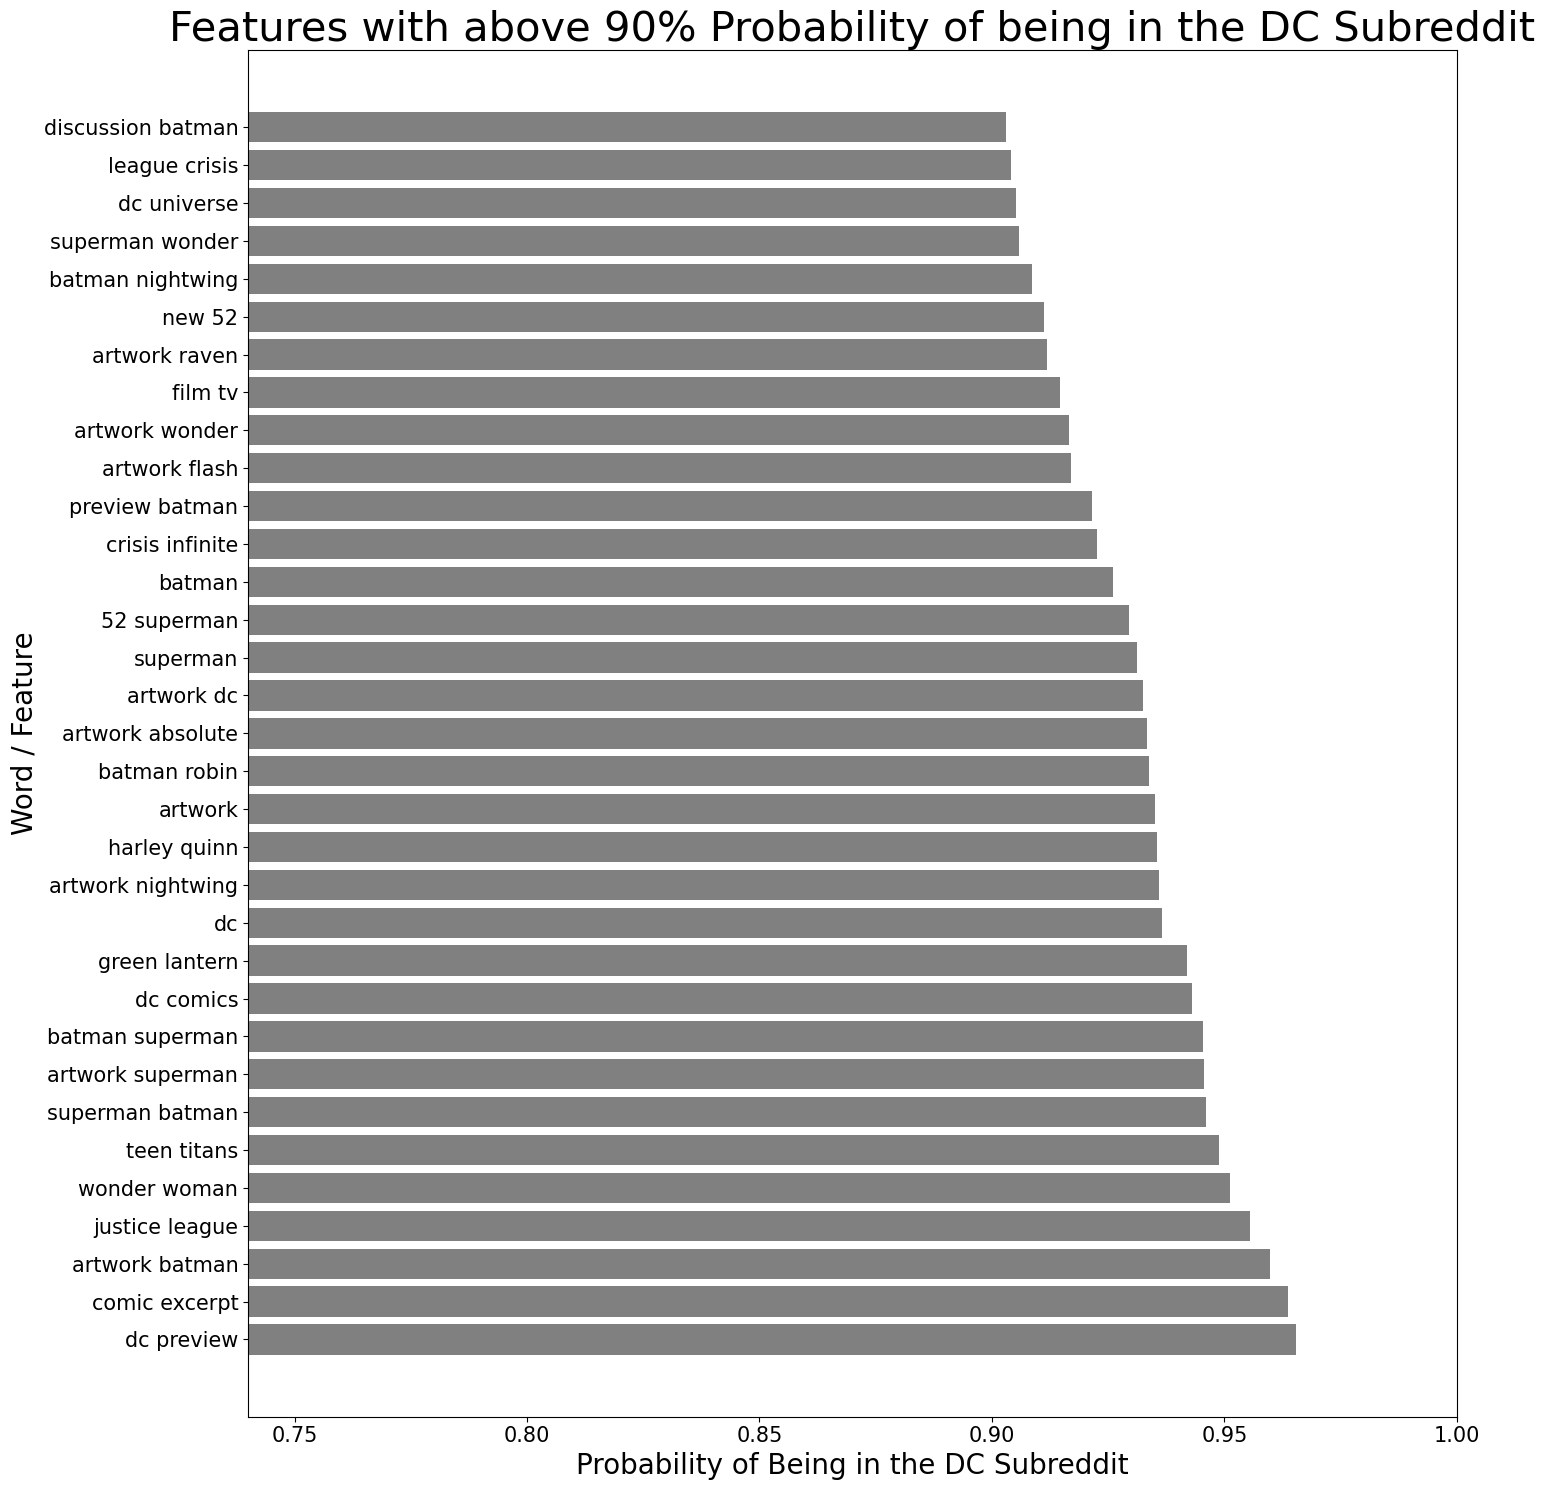

In [36]:
plt.figure(figsize = (15,15))

ax = plt.gca()

plt.barh(most_dc_words['features'],
         most_dc_words['dc_probability'],
        color = 'grey');

ax.set_xlim([0.74, 1]) #https://stackoverflow.com/questions/3777861/how-to-set-the-axis-limits

plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel('Probability of Being in the DC Subreddit', size = 20)
plt.ylabel('Word / Feature', size = 20)
plt.title('Features with above 90% Probability of being in the DC Subreddit', size = 30)

plt.tight_layout()

In [38]:
# Features with above 75% probability of being in the Marvel Subreddit
most_marvel_words = word_probabilities[word_probabilities['marvel_probability'] > 0.9].sort_values('marvel_probability')
most_marvel_words

,features,dc_probability,marvel_probability
153,adaptation outside,0.099165,0.900835
536,best marvel,0.098146,0.901854
404,avengers men,0.098070,0.901930
2311,men characters,0.098046,0.901954
2234,man wolverine,0.096336,0.903664
2232,man spider,0.094110,0.905890
2267,marvel legends,0.093111,0.906889
709,captain america,0.091261,0.908739
3005,scarlet spider,0.090475,0.909525
2260,marvel,0.090329,0.909671


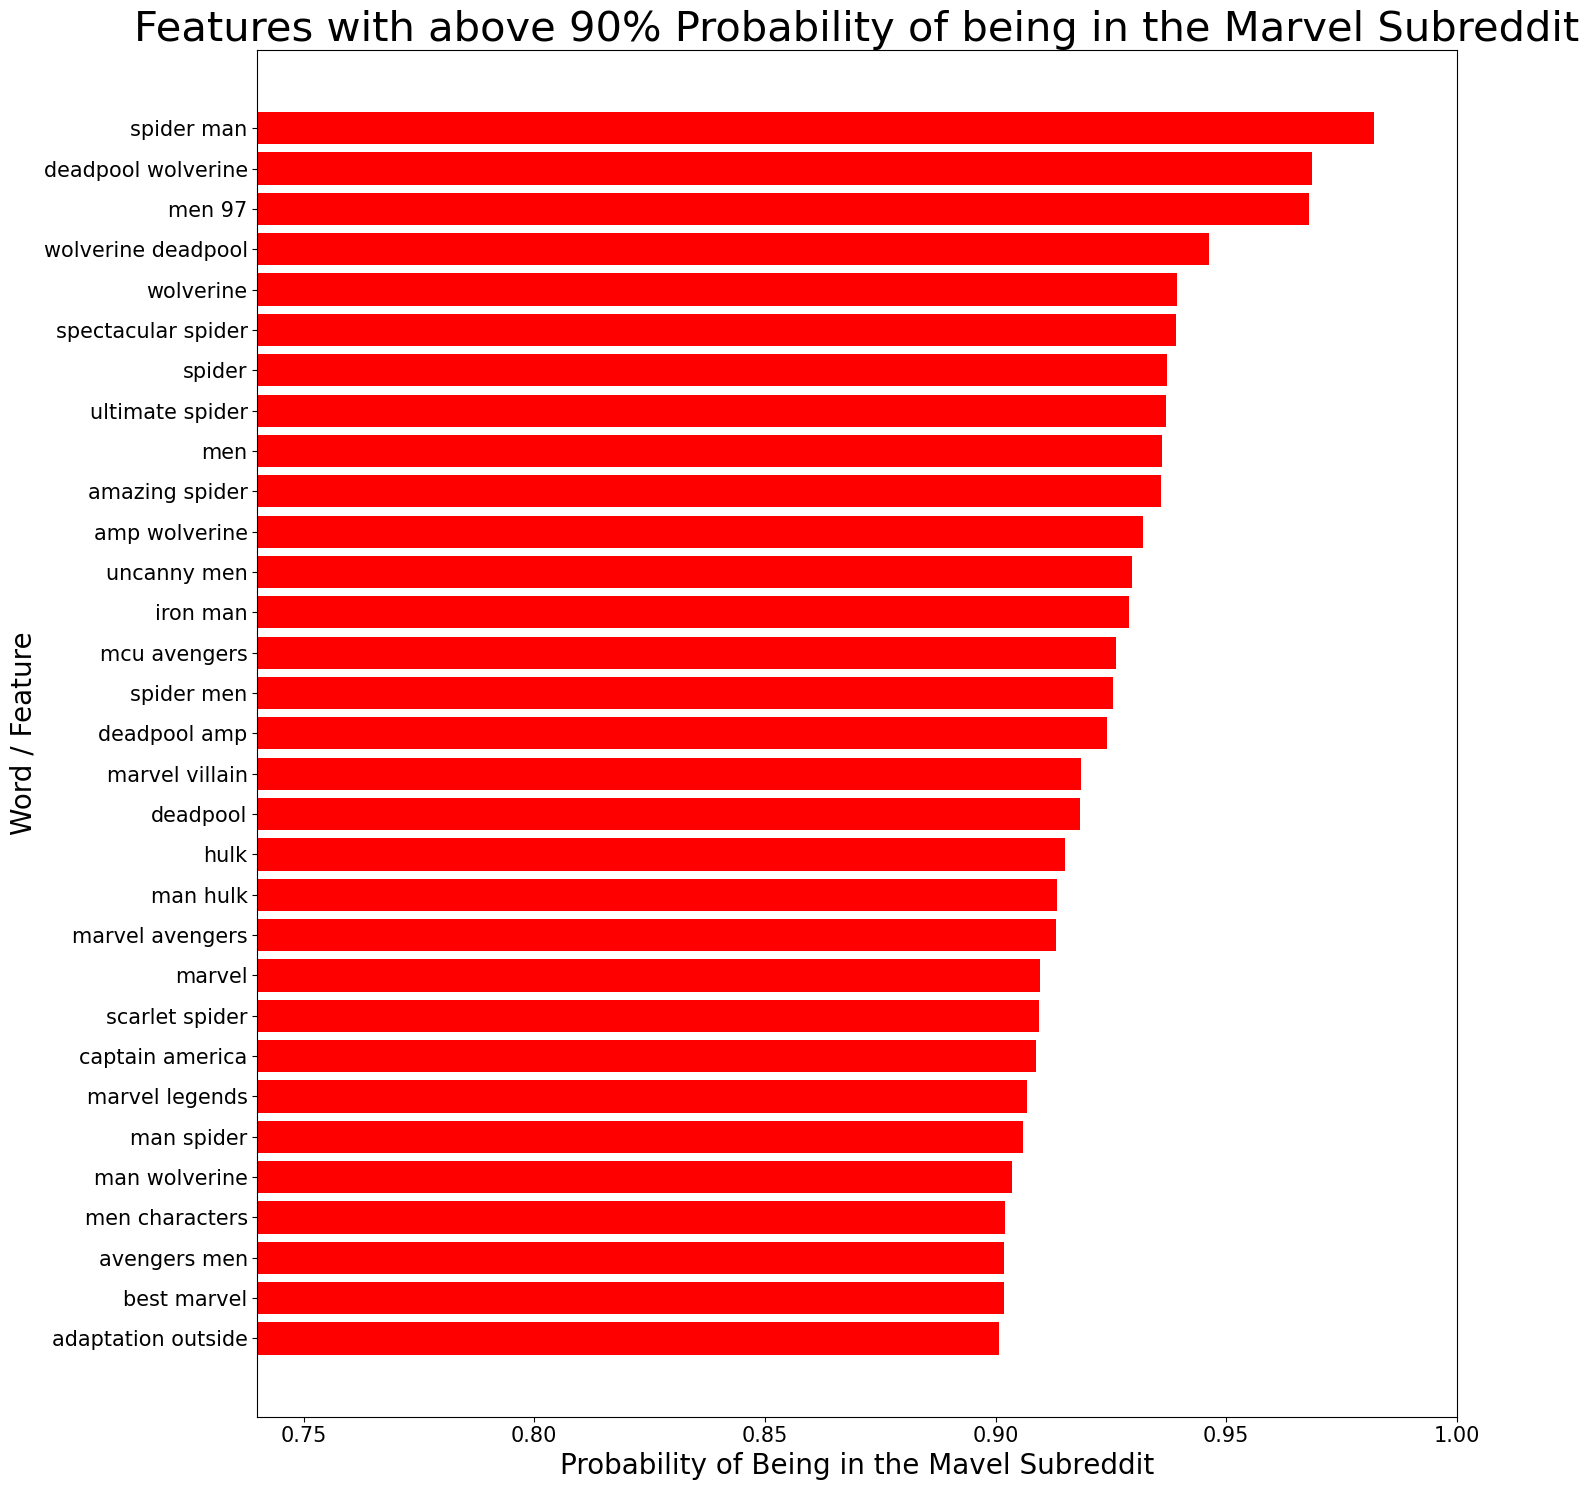

In [39]:
plt.figure(figsize = (15,15))

ax = plt.gca()

plt.barh(most_marvel_words['features'],
         most_marvel_words['marvel_probability'],
        color = 'red');

ax.set_xlim([0.74, 1]) #https://stackoverflow.com/questions/3777861/how-to-set-the-axis-limits

plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel('Probability of Being in the Mavel Subreddit', size = 20)
plt.ylabel('Word / Feature', size = 20)
plt.title('Features with above 90% Probability of being in the Marvel Subreddit', size = 30)

plt.tight_layout()

In [40]:
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, pred).ravel()

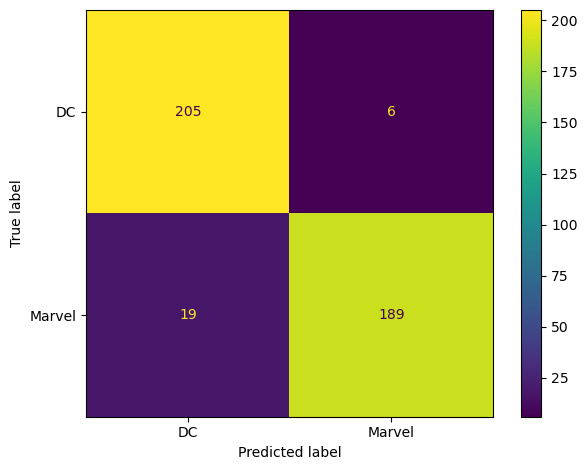

In [41]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, 
                                      display_labels = ['DC', 'Marvel'], #Adding labels to identify which company is which
                                      );

plt.tight_layout()

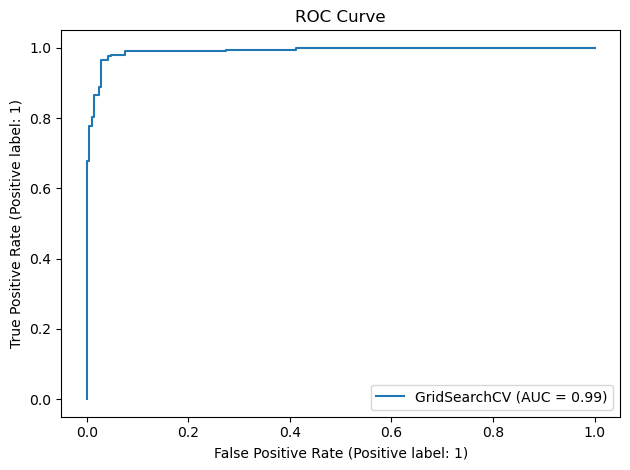

In [42]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

plt.title('ROC Curve')

plt.tight_layout()

In [50]:
gs.best_estimator_.named_steps.tf.get_feature_names_out()

array(['10', '100', '1064', ..., 'zero', 'zone', 'zucco'], dtype=object)

#### These are the 50 words/phrases that are common in one document (post) but not common in the rest of the corpus (all the other posts)

In [44]:
pd.DataFrame(index = gs.best_estimator_.named_steps.tf.get_feature_names_out(),
             data = gs.best_estimator_.named_steps.tf.idf_,
             columns = ['idf_score']).sort_values(by = 'idf_score', ascending = False).head(50)

,idf_score
war comes,7.037871
country,7.037871
crisis events,7.037871
crisis earths,7.037871
criminal mastermind,7.037871
crime syndicate,7.037871
crew,7.037871
week soundtrack,7.037871
creature,7.037871
creators reacting,7.037871


### These are common words across all documents (posts)

In [45]:
pd.DataFrame(index = gs.best_estimator_.named_steps.tf.get_feature_names_out(),
             data = gs.best_estimator_.named_steps.tf.idf_,
             columns = ['idf_score']).sort_values(by = 'idf_score', ascending = False).tail(20)

,idf_score
did,3.625624
character,3.614695
fan,3.603884
does,3.561772
good,3.541363
superman,3.463654
ve,3.454352
read,3.409095
new,3.374309
art,3.348991


In [47]:
#The text it is predicting incorrectly: https://stackoverflow.com/questions/71928062/identifying-misclassified-raw-data-in-after-machine-learning-in-python
X_test[y_test != pred]

1017    any thor fans out there interested in thr 3 oz...
1381                                               i spy 
685     what are your thoughts on the start of house o...
119     help with dc characters i was always more of a...
1379                                   g.o.d.s 7 preview 
1579    galactic how is galactus actually standing in ...
1201                 glasses or goggles for the next con 
1081                     art i like 2 by bendis and finch
1062                                        almost there 
1410    can someone explain captain britain 's powers ...
553     what are some fictional characters in dc like ...
1654    is there any difference between livewires trad...
954     reinforcements have arrived stop motion animat...
1224                   who is your favorite team and why 
214            \n josh keaton 's web warriors 🕸 ️ \n \n\n
1119                     flaming fist ghostrider cosplay 
1505                                  what comic is this 
1302          

In [48]:
incorrect = pd.DataFrame(X_test[y_test != pred])
incorrect

,clean_text
1017,any thor fans out there interested in thr 3 oz...
1381,i spy
685,what are your thoughts on the start of house o...
119,help with dc characters i was always more of a...
1379,g.o.d.s 7 preview
1579,galactic how is galactus actually standing in ...
1201,glasses or goggles for the next con
1081,art i like 2 by bendis and finch
1062,almost there
1410,can someone explain captain britain 's powers ...


### Most of the ones its getting wrong are ones the model isn't confident in.

Only 2 of the 25 it gets wrong does it think there's more than a two-thirds chance it is one subreddit or the other
Only 6 of the 25 it gets wrong does it think there's more than 60% chance it is one subreddit or another

In [49]:
pd.set_option('display.max_colwidth', 500)
incorrect_df = incorrect.join([df['subreddit'], probabilities]).sort_values(1)
# Renaming columns for output
incorrect_df.rename(columns = {0 : 'DC Probability', 
                               1 : 'Marvel Probability',
                              'clean_text' : 'Clean Text',
                              'subreddit' : 'Subreddit'}, inplace = True)

In [51]:
len(incorrect_df)

25

In [64]:
incorrect_df['Subreddit'].replace( {0 : 'DC', 1 : 'Marvel'}, inplace = True )
incorrect_df[['Clean Text', 'Subreddit', 'Marvel Probability']]

,Clean Text,Subreddit,Marvel Probability
1505,what comic is this,Marvel,0.162889
1604,who 's autograph is this found a french black panther comic \n does anyone know the signature is on the cover,Marvel,0.316420
1023,took a stab at making my own action figure comic book cover,Marvel,0.366051
1379,g.o.d.s 7 preview,Marvel,0.402259
1628,is what modern spider- man run is worth reading i was wanting to read nick spencer ’s run of sm but heard he messes up his story or it ’s really bad etc and just wondering if there ’s a better recent current ongoing sm comic that i should read \n,Marvel,0.445635
1224,who is your favorite team and why,Marvel,0.495747
1066,anyone know which version of galactus this is curious cause i ’ve never seen this version before anyone know anything about him or know his name,Marvel,0.498882
1654,is there any difference between livewires trades with blue or red spines i 've been interested in picking up the livewires trade but i always see two a blue and a red spine \n\n i just wanted to know if there 's a difference and what it is i wanna make sure i 'm not gon na end up getting a black and white reprint or a smaller copy or something,Marvel,0.499925
725,i prefer to read clark and bruce as supporting or supporting main rather then the focus i enjoy them both as a supporting characters they 're fun to read but i do as much enjoy picking up a comic when it is their story only about them \n\n granted i 've read very few of them as main so i 'm happy for some recs to change my mind,DC,0.500924
119,help with dc characters i was always more of a marvel guy when it came to comics i watched dc movies but have read any dc comics other then the batman prey storyline i some recommendations for characters you think i would like some of my favorite characters from marvel are wolverine punisher ghost rider and spider man another one of my favorite super hero is not from marvel or dc he is the crow if you know you know any characters recommendations based on some of my favorites from other things,DC,0.514172
